# Energy Supply Analysis by Country for the year 2013
### Correlation to GDP and Scientific Journal Contributions

(This analysis was inspired by an MOOC assignment.)

## Introduction  
This analysis explores the relationship between a country's Energy production during the year 2013 and Gross Domestic Product. I expect a high, positive correlation between Energy output and GDP.  

Additional analysis into Renewable Energy production is also provided as an add-on investigation.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - I believe the relationship between the percentage of Energy Supply that is Renewable and GDP to be less clear.
 
Additional analysis into Scientific Journal Contributions regarding Energy Engineering and Power Technology is also provided as an add-on investigation in search of secondary insights.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - Perhaps there exists a stronger pattern between Countries with high GDP and Scientific Journal Contributions.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - Perhaps there exists a stronger pattern between Countries with high GPD and Scientific Journal Contributions and Renewable Energy %.

## Data Sources
1. Energy data for the year 2013 provided by the United Nations  
  * Includes the following information by country:  
    * Country Name
    * Energy Supply in Petajoules  
    * Energy Supply per Capita in Gigajoules  
    * Percentage of Energy Production that is Renewable
2. GDP data for the years 1960-2015 provided by the World Bank.  
  * Includes the following information by country:  
    * Country Name  
    * Country Code  
    * [1960-2015] GDP in USD
3. Ranking of Countries by number of Scientific Journal Contributions regarding Energy Engineering and Power Technology provided by Scimago  
  * Includes the following information by country:  
    * Country Name
    * Number of Documents
    * Number of Citable Documents

In [2]:
import pandas as pd
import numpy as np

### Data processing

In [3]:
def extract_energy():
    # Reads from Energy Indicators.xls
    # Returns a dataframe
    
    # Extract Energy data from Energy Indicators.
    energy = pd.read_excel('Energy Indicators.xls',skiprows = 16, skipfooter = 37)
    energy.drop(energy.columns[[0,1]], axis = 1, inplace = True)
    energy.drop([0], inplace = True)
    
    # Drop empty rows
    energy = energy[energy['Energy Supply'].apply(lambda x: isinstance(x,(int,np.int64)))]
    
    # Rename columns
    energy.rename(columns={'Unnamed: 2' : 'Country', 'Energy Supply per capita' : 'Energy Supply per Capita','Renewable Electricity Production' : '% Renewable'}, inplace = True)
    
    # Cleanse Country Names
    energy.Country = energy.Country.str.replace('\d+', '')
    energy['Country'] = energy['Country'].str.replace(r"\s\(.*\)","")
    energy['Country'].replace({"Republic of Korea": "South Korea","United States of America": "United States",
                   "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
                   "China, Hong Kong Special Administrative Region": "Hong Kong"}, inplace = True)
    
    #Cnovert data types
    energy['Energy Supply'] = pd.to_numeric(energy['Energy Supply'])
    energy['Energy Supply per Capita'] = pd.to_numeric(energy['Energy Supply per Capita'])
    energy['% Renewable'] = pd.to_numeric(energy['% Renewable'])
    
    # Convert Energy Supply from petajoules to gigajoules
    energy['Energy Supply'] *= 1000000
    
    # Calculate Renewable Energy Output and Non-Renewable Energy Output
    energy['Renewable Energy Supply'] = energy['Energy Supply'] * (energy['% Renewable']/100)
    energy['Non-Renewable Energy Supply'] = energy['Energy Supply'] - energy['Renewable Energy Supply']
    
    return energy
    

In [4]:
def extract_GDP():
    # Reads from world_bank.csv
    # Returns a dataframe
    
    # Extract GDP data from world_bank.csv
    GDP = pd.read_csv('world_bank.csv',skiprows = 4)
    # Cleanse Country Names
    GDP['Country Name'].replace({"Korea, Rep.": "South Korea", "Iran, Islamic Rep.": "Iran",
                                 "Hong Kong SAR, China": "Hong Kong"}, inplace = True)
    
    # Calculate average GDP for 2013 and 10 years prior
    years = ['2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013']
    GDP['Average GDP'] = GDP[years].mean(axis = 1)
        
    return GDP

In [5]:
def extract_ScimEn():
    # Reads from scimagojr-3.xlsx
    # Returns a dataframe
    
    # Extract Scientific Journal Contribution data from scimagojr-3.xlsx
    ScimEn = pd.read_excel('scimagojr-3.xlsx')
    ScimEn['Rank'] = ScimEn.index
    ScimEn.rename(columns = {'Citable documents' : 'Citable Documents'}, inplace = True)
    
    return ScimEn

In [6]:
def merge_energyGDPScimEn(energy, GDP, ScimEn):
    # Merge Energy, GDP, and Scientific Journal Contributions (on Country)
    relevant_GDP_cols = ['Country Name','Average GDP']
    relevant_ScimEn_cols = ['Country','Rank','Documents','Citable Documents']
    
    # Energy <-> GDP
    energy_GDP = pd.merge(energy, GDP[relevant_GDP_cols], left_on = 'Country', right_on = 'Country Name')
    energy_GDP.drop('Country Name', axis = 1, inplace = True)
    
    # Energy_GDP <-> ScimEn
    energy_GDP_ScimEn = pd.merge(energy_GDP, ScimEn[relevant_ScimEn_cols], left_on='Country', right_on = 'Country')
    energy_GDP_ScimEn.set_index('Country', inplace = True)
    
    return energy_GDP_ScimEn

In [7]:
def create_dataframe():
    # Extract individual datasets
    energy = extract_energy()
    GDP = extract_GDP()
    ScimEn = extract_ScimEn()
    
    # Join datasets
    energy_GDP_ScimEn = merge_energyGDPScimEn(energy, GDP, ScimEn)   
       
    # Drop Countries with incomplete data
    energy_GDP_ScimEn.dropna(inplace = True)
    
    return energy_GDP_ScimEn

In [8]:
preview = create_dataframe().sort_values('Rank').head(15)
preview

,Energy Supply,Energy Supply per Capita,% Renewable,Renewable Energy Supply,Non-Renewable Energy Supply,Average GDP,Rank,Documents,Citable Documents
Country,,,,,,,,,
China,127191000000,93,19.754910,2.512647e+10,1.020645e+11,5.097527e+12,0,127050,126767
United States,90838000000,286,11.570980,1.051085e+10,8.032715e+10,1.479284e+13,1,96661,94747
Japan,18984000000,149,10.232820,1.942599e+09,1.704140e+10,5.460244e+12,2,30504,30287
United Kingdom,7920000000,124,10.600470,8.395572e+08,7.080443e+09,2.407734e+12,3,20944,20357
Russian Federation,30709000000,214,17.288680,5.309181e+09,2.539982e+10,1.451768e+12,4,18534,18301
Canada,10431000000,296,61.945430,6.461528e+09,3.969472e+09,1.588637e+12,5,17899,17620
Germany,13261000000,165,17.901530,2.373922e+09,1.088708e+10,3.380018e+12,6,17027,16831
India,33195000000,26,14.969080,4.968986e+09,2.822601e+10,1.484196e+12,7,15005,14841
France,10597000000,166,17.020280,1.803639e+09,8.793361e+09,2.619989e+12,8,13153,12973


### Correlation Calculations

In [9]:
df = create_dataframe()
df[['Average GDP', 'Energy Supply', 'Non-Renewable Energy Supply','Renewable Energy Supply','Citable Documents']].corr()

,Average GDP,Energy Supply,Non-Renewable Energy Supply,Renewable Energy Supply,Citable Documents
Average GDP,1.000000,0.781260,0.798680,0.635768,0.824882
Energy Supply,0.781260,1.000000,0.996748,0.930170,0.977665
Non-Renewable Energy Supply,0.798680,0.996748,1.000000,0.897560,0.973764
Renewable Energy Supply,0.635768,0.930170,0.897560,1.000000,0.912683
Citable Documents,0.824882,0.977665,0.973764,0.912683,1.000000


### Visualization

In [40]:
import matplotlib.pyplot as plt

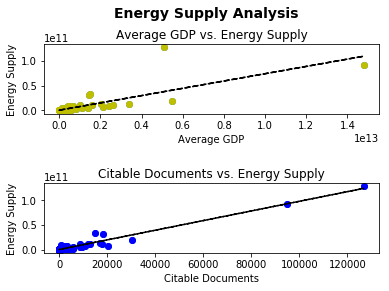

In [92]:
df = create_dataframe()

# Set up figure
fig = plt.figure()
fig.suptitle('Energy Supply Analysis', fontsize=14, fontweight='bold')


# Set up axes data
# Average GDP vs Energy Supply
X = df['Average GDP']
y = df['Energy Supply']

fit = np.polyfit(X,y,1)
fit_fn = np.poly1d(fit) 

# Add subplot
ax = fig.add_subplot(211)
fig.subplots_adjust(top = 0.85, hspace = 1)

# Add labels
ax.set_title('Average GDP vs. Energy Supply')
ax.set_xlabel('Average GDP')
ax.set_ylabel('Energy Supply')

# Plot
ax.scatter('Average GDP', 'Energy Supply', data=df, marker='o')
ax.plot(X, y, 'yo', X, fit_fn(X), '--k')


# Citable Documents vs Energy Supply
X2 = df['Citable Documents']
y = df['Energy Supply']

fit2 = np.polyfit(X2,y,1)
fit_fn2 = np.poly1d(fit2) 


# Add subplot
ax2 = fig.add_subplot(212)

# Add labels
ax2.set_title('Citable Documents vs. Energy Supply')
ax2.set_xlabel('Citable Documents')
ax2.set_ylabel('Energy Supply')

# Plot
ax2.scatter('Citable Documents', 'Energy Supply', data=df, marker='o')
ax2.plot(X2, y, 'bo', X2, fit_fn2(X2), '--k')

plt.show()

## Conclusion
It would seem that the two metrics with the highest correlation are Citable Documents with Total Energy Supply.
It is also heartening to see that there is a similarly strong correlation between Citable Documents and Renewable Energy Supply, as that may imply that much of the research done on Energy Engineering is improving Renewable Energy capacities.

Intuitively, one would think that there would be a stronger correlation between GDP and Citable Documents as a higher GDP generally indicates a stronger education system. However, for this analysis, the data is restricted in scope to Scientific Journals regarding Energy Engineering and many countries may not necessarily focus research on Energy if that is not one of their nation's major outputs.

### Assumptions Made
1. Energy production requires heavy infrastructure, which can take years to implement. Therefore, I am considering the average GDP of the 2013 and the prior 10 years as countries with a higher GDP over that time period will likely have higher Energy Output Capacity than countries that only recently began to experience GDP growth.

2. Countries with high GDP will likely have immense non-Renewable Energy foundations already implemented. As a result, Percentage of Renewable Energy will appear deflated compared to countries that are not weighed down by pre-existing infrastructures. Therefore, I am considering Renewable Energy Supply rather than Percentage of Renewable Energy.

## Other Notable Metrics

In [10]:
def topPercentRenewable(df):    
    # Countries in the top 50th Percentile in terms of % Renewable, sorted by Rank (according to Scientific Journal Contributions)
    # Inputs dataframe
    # Returns a dataframe
    
    # Calculate median
    median = df['% Renewable'].median()
    df_top = df[df['% Renewable'] > median]
    
    # Sort by Journal Contributions rank
    df_top = df_top.sort_values(by = 'Rank')
    return df_top[['% Renewable', 'Rank']]

df = create_dataframe()
topPercentRenewable(df).head(10)

,% Renewable,Rank
Country,,
Canada,61.94543,5
Italy,33.66723,10
Spain,37.96859,11
Brazil,69.64803,14
Turkey,28.53669,16
Norway,97.63558,17
Sweden,46.59846,19
Switzerland,57.74548,21
Denmark,33.53766,22


In [19]:
def popByContinent(df):
    # Popoluation metrics for countries grouped into corresponding Continents
    # Inputs dataframe
    # Returns a dataframe
    
    # Estimate population
    df['Population'] = df['Energy Supply'] / df['Energy Supply per Capita']
    
    # Group by continent
    ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}
    
    return df.groupby(by = ContinentDict)['Population'].agg([np.size, np.sum, np.mean, np.std])

df = create_dataframe()
popByContinent(df).head(10)

,size,sum,mean,std
Asia,5.0,2.898666e+09,5.797333e+08,6.790979e+08
Australia,1.0,2.331602e+07,2.331602e+07,NaN
Europe,6.0,4.579297e+08,7.632161e+07,3.464767e+07
North America,2.0,3.528552e+08,1.764276e+08,1.996696e+08
South America,1.0,2.059153e+08,2.059153e+08,NaN


In [23]:
def bucketContinents(df):
    # Bucket Continents into 5 bins by % Renewable
    # Returns as a Series each Continent, the buckets in each Continent, 
    # and the number of countries that belong to each of said buckets
    
    buckets = pd.cut(df['% Renewable'], 5)
    ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}
    
    return pd.Series(df.groupby(by = [ContinentDict, buckets]).size())
    
df = create_dataframe()
print(bucketContinents(df))

               % Renewable 
Asia           (-0.1, 20.0]    5
Australia      (-0.1, 20.0]    1
Europe         (-0.1, 20.0]    4
               (20.0, 40.0]    2
North America  (-0.1, 20.0]    1
               (60.0, 80.0]    1
South America  (60.0, 80.0]    1
dtype: int64


In [39]:
def popByRank(df):
    # Inputs a dataframe
    # Returns a dataframe
    # Formatted population size of top 10 countries sorted by Rank according to Sciamago
    
    # Calculate population size
    df['Population'] = df['Energy Supply'] / df['Energy Supply per Capita']
    
    # Sort by Rank
    df.sort_values(by = 'Rank', inplace = True)
    
    # Only Population of top 10 countries is relevant
    df = df['Population']
    df = df.head(10)
    
    return df.apply(lambda x: "{:,.0f}".format(x))
    
popByRank(df).head(10)

Country
China                 1,367,645,161
United States           317,615,385
Japan                   127,409,396
United Kingdom           63,870,968
Russian Federation      143,500,000
Canada                   35,239,865
Germany                  80,369,697
India                 1,276,730,769
France                   63,837,349
South Korea              49,805,430
Name: Population, dtype: object